In [1]:
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt


class Company:
    url_prefix = "https://financialmodelingprep.com/api/v3/financials/"

    def __init__(self, ticker):
        self.ticker = ticker
        self.balance_sheet = None
        self.income_statements = None
        self.cashflow_statements = None
        self.profitability_insights = None
        self.operating_insights = None
        self.solvency_insights = None
        self.profile_url = f"https://financialmodelingprep.com/api/v3/company/profile/{ticker}"
        self.bs_url = f"{Company.url_prefix}/balance-sheet-statement/{ticker}"
        self.is_url = f"{Company.url_prefix}/income-statement/{ticker}"
        self.cf_url = f"{Company.url_prefix}/cash-flow-statement/{ticker}"

    def __get_balance_sheet(self, quarterly=False):
        bs_items = ["date", "Cash and short-term investments", "Receivables", "Inventories", "Total current assets",
                    "Property, Plant & Equipment Net", "Goodwill and Intangible Assets", "Long-term investments",
                    "Total non-current assets", "Total assets", "Payables", "Deposit Liabilities","Short-term debt",
                    "Deferred revenue", "Total current liabilities", "Long-term debt", "Total non-current liabilities",
                    "Total liabilities", "Retained earnings (deficit)", "Total shareholders equity"]
        data = requests.get(self.bs_url + ("?period=quarter" if quarterly else "")).json()['financials']
        data = pd.DataFrame.from_dict(data)[bs_items]
        data.reindex(bs_items)
        self.balance_sheet = data.T
        self.balance_sheet.columns = self.balance_sheet.iloc[0]
        self.balance_sheet = self.balance_sheet[1:].apply(pd.to_numeric, errors='coerce')

    def __get_income_statements(self, quarterly=False):
        is_items = ["date", "Revenue", "Cost of Revenue", "Gross Profit", "R&D Expenses", "SG&A Expense",
                    "Interest Expense", "Income Tax Expense", "Operating Income", "EBITDA", "EBIT",
                    "Earnings before Tax", "Net Income"]
        is_insights = ["date", "Revenue Growth", "Gross Margin", "Net Profit Margin", "Free Cash Flow margin"]
        data = requests.get(self.is_url + ("?period=quarter" if quarterly else "")).json()['financials']
        data = pd.DataFrame.from_dict(data)[is_items + is_insights[1:]]
        data.reindex(is_items + is_insights)
        self.income_statements = data[is_items].T
        self.income_statements.columns = self.income_statements.iloc[0]
        self.income_statements = self.income_statements[1:].apply(pd.to_numeric, errors='coerce')
        self.profitability_insights = data[is_insights].T
        self.profitability_insights.columns = self.profitability_insights.iloc[0]
        self.profitability_insights = self.profitability_insights[1:].apply(pd.to_numeric, errors='coerce')

    def __get_cashflow_statements(self, quarterly=False):
        cf_items = ["date", "Operating Cash Flow", "Financing Cash Flow", "Investing Cash flow",
                    "Net cash flow / Change in cash", "Free Cash Flow"]
        data = requests.get(self.cf_url + ("?period=quarter" if quarterly else "")).json()['financials']
        data = pd.DataFrame.from_dict(data)[cf_items]
        data.reindex(cf_items)
        self.cashflow_statements = data.T
        self.cashflow_statements.columns = self.cashflow_statements.iloc[0]
        self.cashflow_statements = self.cashflow_statements[1:].apply(pd.to_numeric, errors='coerce')

    def print_balance_sheet(self, quarterly=False, show_plot=False):
        if self.balance_sheet is None:
            self.__get_balance_sheet(quarterly)
        print(f"========{self.ticker} Balance Sheet========")
        print(self.balance_sheet.to_string(max_rows=100, max_cols=100))
        self.balance_sheet.T.iloc[::-1][["Cash and short-term investments", "Receivables", "Inventories",
                                         "Total assets", "Total liabilities", "Retained earnings (deficit)",
                                         "Total shareholders equity"]].plot.line(subplots=True,
                                                                                 title=f"{self.ticker} Balance Sheet")
        if show_plot:
            plt.show()

    def print_income_statements(self, quarterly=False, show_plot=False):
        if self.income_statements is None:
            self.__get_income_statements(quarterly)
        print(f"========{self.ticker} Income Statements========")
        print(self.income_statements.to_string(max_rows=100, max_cols=100))
        self.income_statements.T.iloc[::-1][["Revenue", "Cost of Revenue", "Gross Profit", "R&D Expenses",
                                             "SG&A Expense", "Interest Expense", "Income Tax Expense",
                                             "Operating Income", "Net Income"]].plot.line(subplots=True,
                                                                               title=f"{self.ticker} Income Statements")
        if show_plot:
            plt.show()

    def print_cashflow_statements(self, quarterly=False, show_plot=False):
        if self.cashflow_statements is None:
            self.__get_cashflow_statements(quarterly)
        print(f"========{self.ticker} Cashflow Statements========")
        print(self.cashflow_statements.to_string(max_rows=100, max_cols=100))
        self.cashflow_statements.T.iloc[::-1].plot.line(subplots=True, title=f"{self.ticker} Cash Flow Statements")
        if show_plot:
            plt.show()

    def get_profitability_insights(self, quarterly=False, show_plot=False):
        if self.balance_sheet is None:
            self.__get_balance_sheet(quarterly)
        if self.income_statements is None:
            self.__get_income_statements(quarterly)

        data = self.profitability_insights.T
        data['Return on total assets'] = round(self.income_statements.loc['Net Income']/
                                               self.balance_sheet.loc['Total assets'], 4)
        self.profitability_insights = data.T
        self.profitability_insights.insert(loc=0, column="mean", value=self.profitability_insights.mean(axis=1))
        print(f"========{self.ticker} Profitability Analysis========")
        print(self.profitability_insights.to_string(max_rows=100, max_cols=100))
        self.profitability_insights.T.iloc[:0:-1].plot.line(title=f"{self.ticker} Profitability Analysis")
        if show_plot:
            plt.show()

    def get_operating_insights(self, quarterly=False, show_plot=False):
        if self.balance_sheet is None:
            self.__get_balance_sheet(quarterly)
        if self.income_statements is None:
            self.__get_income_statements(quarterly)
        ins = self.income_statements.T
        bs = self.balance_sheet.T
        self.operating_insights = pd.concat([
                          round(365/(ins["Revenue"]/bs["Cash and short-term investments"]), 2),
                          round(365/(ins["Revenue"]/bs["Receivables"]), 2),
                          round(365/(ins["Cost of Revenue"]/bs['Inventories']), 2),
                          round(365/(ins["Revenue"]/bs["Total current assets"]), 2),
                          round(365/(ins["Revenue"]/bs["Property, Plant & Equipment Net"]), 2),
                          round(365/(ins["Revenue"]/bs["Total assets"]), 2)], axis=1)
        self.operating_insights.columns = ["cash turnover days", "receivables turnover days",
                                           "inventories turnover days", "total current assets turnover days",
                                           "fixed assets turnover days", "total assets turnover days"]
        self.operating_insights = self.operating_insights.T
        self.operating_insights.insert(loc=0, column="mean", value=self.operating_insights.mean(axis=1))
        print(f"========{self.ticker} Operating Analysis========")
        print(self.operating_insights.to_string())
        self.operating_insights.T.iloc[:0:-1].plot.line(subplots=True, title=f"{self.ticker} Operating Analysis")
        if show_plot:
            plt.show()

    def get_solvency_insights(self, quarterly=False, show_plot=False):
        if self.balance_sheet is None:
            self.__get_balance_sheet(quarterly)
        if self.income_statements is None:
            self.__get_income_statements(quarterly)
        ins = self.income_statements.T
        bs = self.balance_sheet.T
        self.solvency_insights = pd.concat([
                          round(bs["Total current assets"]/bs["Total current liabilities"], 4),
                          round((bs["Total current assets"]-bs["Inventories"])/bs["Total current liabilities"], 4),
                          round(ins["EBIT"]/ins["Interest Expense"], 4),
                          round(bs["Total liabilities"]/bs["Total assets"], 4)], axis=1)
        self.solvency_insights.columns = ["current ratio", "acid-test ratio", "times interest earned",
                                          "liability/asset ratio"]
        self.solvency_insights = self.solvency_insights.T
        self.solvency_insights.insert(loc=0, column="mean", value=self.solvency_insights.mean(axis=1))
        print(f"========{self.ticker} Solvency Analysis========")
        print(self.solvency_insights.to_string())
        self.solvency_insights.iloc[:0:-1].plot.line(subplots=True, title=f"{self.ticker} Solvency Analysis")
        if show_plot:
            plt.show()

    def get_wacc(self, quarterly=False, show_plot=False):
        pass

    def get_roic(self, quarterly=False, show_plot=False):
        pass

    def get_dfc_valuation(self, quarterly=False, show_plot=False):
        pass

        


========AAPL Profitability Analysis========
date                        mean  2019-09-28  2018-09-29  2017-09-30  2016-09-24  2015-09-26  2014-09-27  2013-09-28  2012-09-29  2011-09-24  2010-09-25  2009-09-26
Revenue Growth          0.013127    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000      0.1444
Gross Margin            0.394407    0.378178    0.383437    0.384699    0.390760    0.400599    0.385880    0.376245    0.438712    0.404789    0.393775      0.4014
Net Profit Margin       0.221225    0.212381    0.224142    0.210924    0.211868    0.228458    0.216144    0.216705    0.266651    0.239466    0.214841      0.1919
Free Cash Flow margin   0.256306    0.226372    0.241424    0.223121    0.246199    0.299591    0.274307    0.266228    0.271941    0.307338    0.254350      0.2085
Return on total assets  0.177227    0.163200    0.162800    0.128800    0.142000    0.183800    0.170400    0.178900    0.237000   

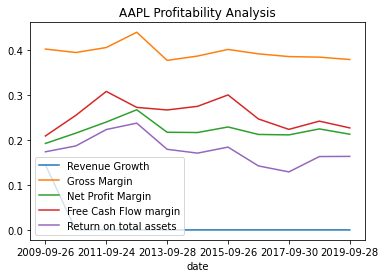

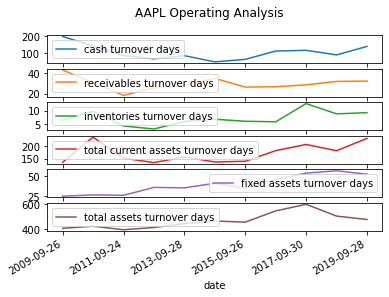

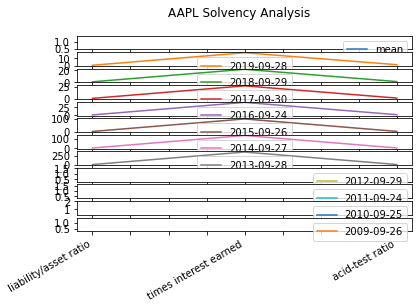

In [4]:
c = Company("AAPL")
c.get_profitability_insights()
c.get_operating_insights()
c.get_solvency_insights()

In [3]:
c.profitability_insights

date,mean,2019-06-30,2018-06-30,2017-06-30,2016-06-30,2015-06-30,2014-06-30,2013-06-30,2012-06-30,2011-06-30,2010-06-30,2009-06-30
Revenue Growth,-0.002982,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.0328
Gross Margin,0.705110,0.659020,0.652474,0.619111,0.615799,0.646954,0.689818,0.739894,0.762218,0.777290,0.801629,0.7920
Net Profit Margin,0.242795,0.311817,0.150154,0.235731,0.196882,0.130295,0.254212,0.280839,0.230294,0.330984,0.300237,0.2493
Free Cash Flow margin,0.262493,0.285054,0.284197,0.060411,0.276477,0.207448,0.239644,0.295341,0.260556,0.352273,0.353627,0.2724
Return on total assets,0.134945,0.136900,0.064000,0.088000,0.086700,0.069200,0.128100,0.153500,0.140000,0.213000,0.217900,0.1871


In [32]:
c.operating_insights

date,mean,2019-06-30,2018-06-30,2017-06-30,2016-06-30,2015-06-30,2014-06-30,2013-06-30,2012-06-30,2011-06-30,2010-06-30,2009-06-30
cash turnover days,361.106364,408.99,442.42,539.61,484.44,376.49,360.28,361.12,312.11,275.39,214.90,196.42
receivables turnover days,78.905455,85.63,87.58,80.31,78.19,69.85,82.15,81.98,78.13,78.21,76.02,69.91
inventories turnover days,26.669091,17.55,25.33,23.24,25.06,32.06,36.05,34.93,23.67,32.15,21.79,21.53
total current assets turnover days,461.358182,509.18,561.13,648.64,597.47,486.43,480.23,475.73,421.25,390.96,325.23,178.69
fixed assets turnover days,64.747273,105.80,97.43,96.31,78.53,57.46,54.69,46.84,40.94,42.59,44.57,47.06
total assets turnover days,702.828182,831.14,856.10,978.28,828.63,687.34,724.61,667.80,600.41,567.28,503.03,486.49
